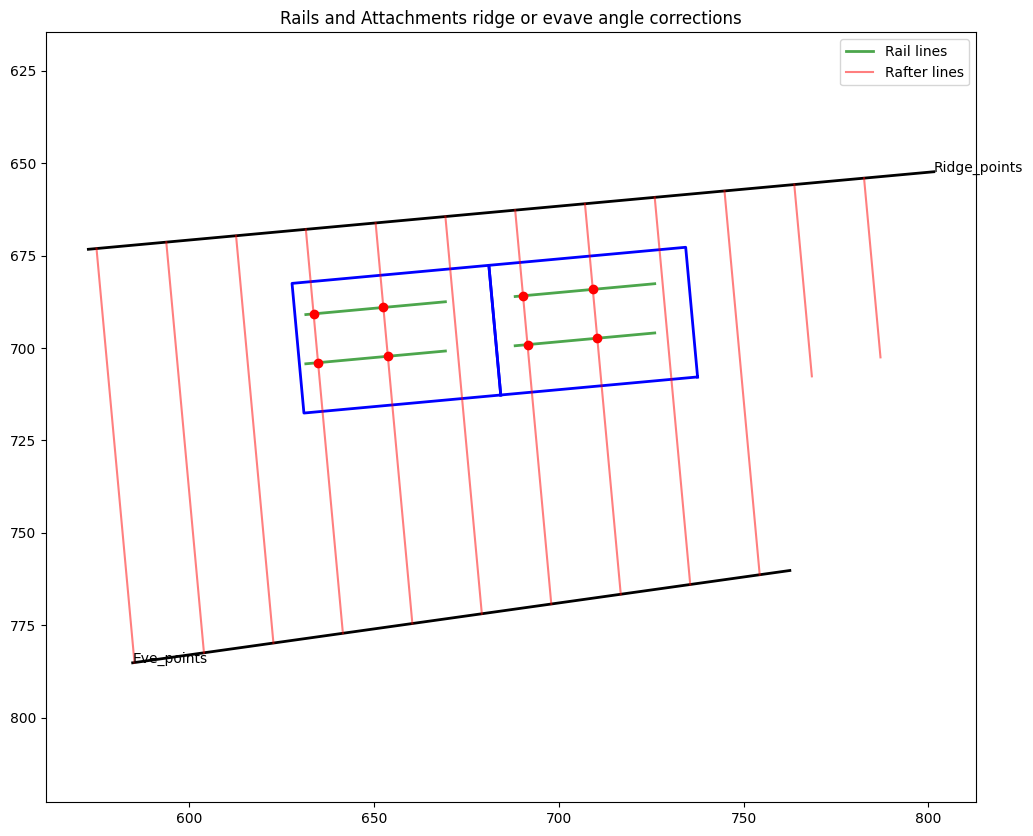

The attachment points are: [(709.180894015555, 684.1515400359749), (690.3022732394244, 685.8828746452812), (710.3924656223328, 697.3626205426187), (691.5138448462021, 699.093955151925), (652.5168211330902, 689.0379335675553), (633.6382003569597, 690.7692681768616), (653.7283927398679, 702.2490140741991), (634.8497719637375, 703.9803486835053)]


In [31]:
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt
import numpy as np


polygon_coords = [
    [
        (737.5289670029157, 707.8383607522512),
        (734.3115701872882, 672.7555904766095),
        (681.0581274146199, 677.639396853694),
        (684.2755242302474, 712.722167129336),
    ],
    [
        (684.2755242302474, 712.722167129336),
        (681.0581274146199, 677.639396853694),
        (627.8046846419517, 682.5232032307786),
        (631.0220814575791, 717.6059735064207),
    ]
]


after_firesetback_points = [
    [563.4131960920918, 683.849716230086],
    [571.2566964320002, 755.1586873236586],
    [721.4685234571397, 734.9041510984856],
    [718.5632461220539, 690.3538023020934],
    [758.5022503287624, 680.3684319624299],
    [757.2853517793179, 662.1138215783843],
    [563.4131960920918, 683.849716230086],
]



ridge_points = (
    [[801.448703847506, 652.3204787645773], [572.7011922497333, 673.298625861141]],
)
eve_points = (
    [[584.6879614164287, 785.1820770428143], [762.4917040557457, 760.208092404048]],
)


rafter_lines = [
    [[782.5700830713754, 654.0518133738835], [787.0169586488396, 702.5409253077241]],
    [[763.6914622952448, 655.7831479831898], [768.4505487273535, 707.6766338002399]],
    [[744.8128415191143, 657.514482592496], [754.3358016835114, 761.353655357538]],
    [[725.9342207429837, 659.2458172018023], [735.5405090690848, 763.9936073746672]],
    [[707.0555999668532, 660.9771518111086], [716.7452164546582, 766.6335593917966]],
    [[688.1769791907225, 662.7084864204148], [697.9499238402316, 769.2735114089259]],
    [[669.2983584145919, 664.4398210297212], [679.1546312258051, 771.9134634260552]],
    [[650.4197376384614, 666.1711556390275], [660.3593386113785, 774.5534154431845]],
    [[631.5411168623308, 667.9024902483337], [641.564045996952, 777.1933674603138]],
    [[612.6624960862002, 669.63382485764], [622.7687533825255, 779.8333194774431]],
    [[593.7838753100697, 671.3651594669462], [603.9734607680989, 782.4732714945724]],
    [[574.9052545339391, 673.0964940762525], [585.1781681536723, 785.1132235117018]],
]

# Create polygon objects
polygons = [Polygon(coords) for coords in polygon_coords]

# Calculate ridge angle
ridge_start, ridge_end = ridge_points[0]
ridge_dx = ridge_end[0] - ridge_start[0]
ridge_dy = ridge_end[1] - ridge_start[1]
ridge_angle = np.arctan2(ridge_dy, ridge_dx)

# Create vertical line segments as LineString objects
vertical_lines = []
for segment in rafter_lines:
    start, end = segment
    line = LineString([(start[0], start[1]), (end[0], end[1])])
    vertical_lines.append(line)

# Create ridge and eve lines
new_ridge_lines = []
new_eve_lines = []
for segment in ridge_points:
    start, end = segment
    line = LineString([(start[0], start[1]), (end[0], end[1])])
    new_ridge_lines.append(line)

for segment in eve_points:
    start, end = segment
    line = LineString([(start[0], start[1]), (end[0], end[1])])
    new_eve_lines.append(line)

# Create 2 horizontal lines per polygon that are aligned with ridge angle
horizontal_lines = []
# Create exactly 2 "horizontal" lines per polygon, aligned with ridge angle
for i, poly_coords in enumerate(polygon_coords):
    # Get polygon object
    polygon = polygons[i]
    
    # Calculate the y-range for this polygon
    y_coords = [y for _, y in poly_coords]
    poly_min_y = min(y_coords)
    poly_max_y = max(y_coords)
    
    # Create 2 evenly spaced "horizontal" lines within this specific polygon's y-range
    # These will now be parallel to the ridge line
    # Position them at 1/3 and 2/3 of the polygon height
    y1 = poly_min_y + (poly_max_y - poly_min_y) / 3
    y2 = poly_min_y + 2 * (poly_max_y - poly_min_y) / 3
    
    # Get leftmost and rightmost rafter lines that intersect with this polygon
    leftmost_x = float('inf')
    rightmost_x = float('-inf')
    leftmost_rafter = None
    rightmost_rafter = None
    
    for line in vertical_lines:
        x_coord = line.coords[0][0]
        if polygon.intersects(line):
            if x_coord < leftmost_x:
                leftmost_x = x_coord
                leftmost_rafter = line
            if x_coord > rightmost_x:
                rightmost_x = x_coord
                rightmost_rafter = line
    
    # If we found rafters, create "horizontal" lines that start and end at the rafters
    # and are aligned with the ridge angle
    if leftmost_rafter and rightmost_rafter:
        # Find points on leftmost and rightmost rafters at the desired heights
        # To do this, we need to shift the y-values according to the ridge angle
        
        # Calculate the horizontal distance between leftmost and rightmost rafters
        dx = rightmost_x - leftmost_x
        
        # Calculate the y-shift for the desired angle over the distance dx
        dy1 = dx * np.tan(ridge_angle)
        
        # Create lines parallel to ridge
        line1_start = (leftmost_x, y1)
        line1_end = (rightmost_x, y1 + dy1)
        line2_start = (leftmost_x, y2)
        line2_end = (rightmost_x, y2 + dy1)
        
        line1 = LineString([line1_start, line1_end])
        line2 = LineString([line2_start, line2_end])
        
        horizontal_lines.append(line1)
        horizontal_lines.append(line2)

# Calculate horizontal-vertical line intersections
h_v_intersections = []
for polygon in polygons:
    for h_line in horizontal_lines:
        for v_line in vertical_lines:
            h_v_point = h_line.intersection(v_line)
            if not h_v_point.is_empty and polygon.contains(h_v_point):
                h_v_intersections.append((h_v_point.x, h_v_point.y))

# Plot everything
plt.figure(figsize=(12, 10))

# Plot polygons
for polygon in polygons:
    x, y = polygon.exterior.xy
    plt.plot(x, y, 'b-', linewidth=2)

# Plot ridge line
for points in new_ridge_lines:
    x, y = points.xy
    plt.plot(x, y, 'k-', linewidth=2)
    plt.text(x[0], y[0], 'Ridge_points', fontsize=10)

# Plot eve line
for points in new_eve_lines:
    x, y = points.xy
    plt.plot(x, y, 'k-', linewidth=2)
    plt.text(x[0], y[0], 'Eve_points', fontsize=10)

# Plot horizontal lines (adjusted to ridge angle)
for line in horizontal_lines:
    x, y = line.xy
    plt.plot(x, y, 'g-', alpha=0.7, linewidth=2, label='Rail lines')

# Plot vertical lines (rafters)
for line in vertical_lines:
    x, y = line.xy
    plt.plot(x, y, 'r-', alpha=0.5, label='Rafter lines')

# Plot attachment points (intersections)
for point in h_v_intersections:
    plt.plot(point[0], point[1], 'ro', markersize=6)

# Get all x and y values for plot limits
x_values = [coord[0] for poly in polygon_coords for coord in poly] + [seg[0][0] for seg in rafter_lines] + [seg[1][0] for seg in rafter_lines]
y_values = [coord[1] for poly in polygon_coords for coord in poly] + [seg[0][1] for seg in rafter_lines] + [seg[1][1] for seg in rafter_lines]

# Set plot limits with some padding
plt.xlim(min(x_values) - 50, max(x_values) + 50)
plt.ylim(min(y_values) - 50, max(y_values) + 50)

plt.title('Rails and Attachments ridge or evave angle corrections')
plt.grid(False)
# Remove duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.axis('equal')
plt.gca().invert_yaxis()
plt.show()

# Print attachment points
attachment_points = [item for item in h_v_intersections]
print("The attachment points are:", attachment_points)

In [ ]:
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt
import numpy as np

points = [{'x': 866.5399899872009, 'y': 659.9121564253597}, {'x': 875.338800284868, 'y': 753.7885971971191}, {'x': 847.6648730310452, 'y': 661.6812751955022}, {'x': 856.470951752996, 'y': 755.6352643833216}, {'x': 828.7897560748895, 'y': 663.4503939656446}, {'x': 837.6031032211243, 'y': 757.481931569524}, {'x': 809.9146391187339, 'y': 665.219512735787}, {'x': 818.7352546892527, 'y': 759.3285987557256}, {'x': 791.0395221625782, 'y': 666.9886315059294}, {'x': 805.6446941332941, 'y': 822.8144210258861}, {'x': 772.1644052064225, 'y': 668.7577502760719}, {'x': 790.967365465647, 'y': 869.3706655899614}, {'x': 753.2892882502668, 'y': 670.5268690462143}, {'x': 772.1767533211356, 'y': 872.041384767077}, {'x': 734.4141712941112, 'y': 672.2959878163567}, {'x': 753.3861411766243, 'y': 874.7121039441926}, {'x': 715.5390543379556, 'y': 674.0651065864992}, {'x': 734.5955290321131, 'y': 877.3828231213082}, {'x': 696.6639373817998, 'y': 675.8342253566416}, {'x': 715.8049168876015, 'y': 880.0535422984238}, {'x': 677.7888204256442, 'y': 677.603344126784}, {'x': 697.0143047430903, 'y': 882.7242614755394}, {'x': 658.9137034694885, 'y': 679.3724628969264}, {'x': 678.2236925985789, 'y': 885.394980652655}, {'x': 640.0385865133328, 'y': 681.1415816670689}, {'x': 659.4330804540676, 'y': 888.0656998297707}, {'x': 621.1634695571772, 'y': 682.9107004372113}, {'x': 640.6424683095562, 'y': 890.7364190068863}, {'x': 602.2883526010215, 'y': 684.6798192073537}, {'x': 621.8518561650449, 'y': 893.4071381840018}, {'x': 583.4132356448658, 'y': 686.4489379774961}, {'x': 603.0612440205334, 'y': 896.0778573611175}, {'x': 564.5381186887103, 'y': 688.2180567476386}, {'x': 584.2706318760222, 'y': 898.748576538233}, {'x': 545.6630017325544, 'y': 689.987175517781}, {'x': 565.4800197315108, 'y': 901.4192957153487}, {'x': 526.7878847763989, 'y': 691.7562942879234}, {'x': 546.6894075869994, 'y': 904.0900148924643}, {'x': 507.9127678202432, 'y': 693.5254130580659}, {'x': 527.8987954424881, 'y': 906.7607340695799}, {'x': 489.03765086408754, 'y': 695.2945318282083}, {'x': 509.1081832979767, 'y': 909.4314532466955}, {'x': 470.1625339079319, 'y': 697.0636505983507}, {'x': 490.31757115346545, 'y': 912.1021724238111}, {'x': 451.2874169517762, 'y': 698.8327693684931}, {'x': 471.52695900895407, 'y': 914.7728916009268}, {'x': 432.4122999956206, 'y': 700.6018881386356}, {'x': 452.73634686444274, 'y': 917.4436107780423}]




array('d', [460.2808112324493, 865.6474258970359, 854.6645865834633, 852.6677067082684, 848.6739469578783, 812.7301092043682, 808.7363494539782, 850.6708268330733, 839.6879875195008, 848.6739469578783, 451.2948517940718, 460.2808112324493])

In [ ]:

existing_points =  [{'x': 812.0185724614914, 'y': 687.6668399490442}]



points =  [{'x': 812.0185724614914, 'y': 687.6668399490442}, {'x': 793.1434555053357, 'y': 689.4359587191866}, {'x': 774.26833854918, 'y': 691.205077489329}, {'x': 813.2593305393607, 'y': 700.9047605620228}, {'x': 794.384213583205, 'y': 702.6738793321653}, {'x': 775.5090966270493, 'y': 704.4429981023077}, {'x': 755.3932215930244, 'y': 692.9741962594715}, {'x': 736.5181046368687, 'y': 694.743315029614}, {'x': 717.6429876807131, 'y': 696.5124337997564}, {'x': 756.6339796708936, 'y': 706.2121168724501}, {'x': 737.7588627147379, 'y': 707.9812356425925}, {'x': 718.8837457585823, 'y': 709.750354412735}, {'x': 758.6808339742058, 'y': 728.0504552696602}, {'x': 739.8057170180501, 'y': 729.8195740398028}, {'x': 720.9306000618946, 'y': 731.5886928099452}, {'x': 759.9215920520751, 'y': 741.2883758826391}, {'x': 741.0464750959194, 'y': 743.0574946527815}, {'x': 722.1713581397638, 'y': 744.826613422924}, {'x': 761.9684463553873, 'y': 763.1267142798497}, {'x': 743.0933293992316, 'y': 764.8958330499921}, {'x': 724.218212443076, 'y': 766.6649518201345}, {'x': 763.2092044332566, 'y': 776.3646348928286}, {'x': 744.3340874771009, 'y': 778.133753662971}, {'x': 725.4589705209453, 'y': 779.9028724331134}, {'x': 765.2560587365689, 'y': 798.2029732900403}, {'x': 746.3809417804132, 'y': 799.9720920601827}, {'x': 727.5058248242576, 'y': 801.7412108303251}, {'x': 766.496816814438, 'y': 811.4408939030185}, {'x': 747.6216998582823, 'y': 813.2100126731609}, {'x': 728.7465829021269, 'y': 814.9791314433033}]


top_x = sorted(points, key=lambda p: p['x'], reverse=True)[:5]
top_y = sorted(points, key=lambda p: p['y'], reverse=True)[:5]


top_points = {tuple(point.items()): point for point in top_x + top_y}.values()


top_points_list = list(top_points)[:5]
top_points_list





[{'x': 812.0185724614914, 'y': 687.6668399490442}, {'x': 813.2593305393607, 'y': 700.9047605620228}, {'x': 812.0185724614914, 'y': 687.6668399490442}, {'x': 794.384213583205, 'y': 702.6738793321653}, {'x': 793.1434555053357, 'y': 689.4359587191866}, {'x': 775.5090966270493, 'y': 704.4429981023077}]


In [7]:
ds = [(793.1434555053357, 689.4359587191866), (813.2593305393607, 700.9047605620228)]
ds2 = [(813.2593305393607, 700.9047605620228), (812.0185724614914, 687.6668399490442)]

ds.extend(ds2)  # This modifies ds directly
print(ds)  # Print the modified list


[(793.1434555053357, 689.4359587191866), (813.2593305393607, 700.9047605620228), (813.2593305393607, 700.9047605620228), (812.0185724614914, 687.6668399490442)]



All intersection points along vertical line at x=2:
1: (2.0, 0.0)
2: (2.0, 1.0)
3: (2.0, 2.5)
4: (2.0, 4.0)
5: (2.0, 5.0)


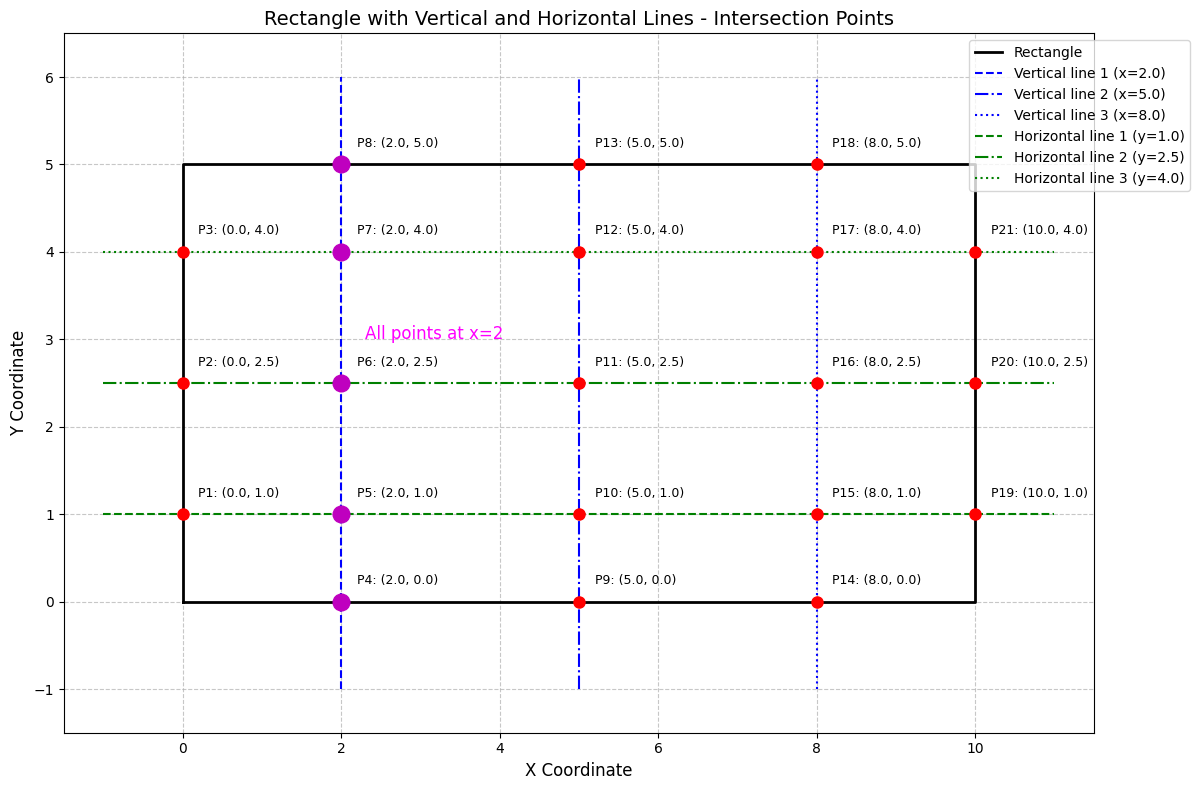


First two intersection points from the left on vertical line x=2:
1: (2.0, 0.0)
2: (2.0, 1.0)


In [7]:
from shapely.geometry import Polygon, LineString
import numpy as np
import matplotlib.pyplot as plt

# Create a rectangle as our main polygon
rect = Polygon([(0, 0), (10, 0), (10, 5), (0, 5)])

# Define 3 vertical lines
v1 = LineString([(2, -1), (2, 6)])  # First vertical line at x=2
v2 = LineString([(5, -1), (5, 6)])
v3 = LineString([(8, -1), (8, 6)])

# Define 3 horizontal lines
h1 = LineString([(-1, 1), (11, 1)])
h2 = LineString([(-1, 2.5), (11, 2.5)])
h3 = LineString([(-1, 4), (11, 4)])

# Find all intersection points
all_intersections = []

# Find intersections of vertical line 1 (x=2) with rectangle and horizontal lines
v1_rect_intersection = rect.intersection(v1)
if v1_rect_intersection.geom_type == 'LineString':
    v1_rect_coords = list(v1_rect_intersection.coords)
    all_intersections.extend(v1_rect_coords)

# Find intersections with horizontal lines
v1_h1_intersection = v1.intersection(h1)
v1_h2_intersection = v1.intersection(h2)
v1_h3_intersection = v1.intersection(h3)

for inter in [v1_h1_intersection, v1_h2_intersection, v1_h3_intersection]:
    if not inter.is_empty:
        all_intersections.extend(list(inter.coords))

# Process the rest of the intersections for completeness
for v_line in [v2, v3]:
    # Intersection with rectangle
    v_rect_intersection = rect.intersection(v_line)
    if v_rect_intersection.geom_type == 'LineString':
        v_rect_coords = list(v_rect_intersection.coords)
        all_intersections.extend(v_rect_coords)
    
    # Intersections with horizontal lines
    for h_line in [h1, h2, h3]:
        inter = v_line.intersection(h_line)
        if not inter.is_empty:
            all_intersections.extend(list(inter.coords))

# Process remaining horizontal line intersections with rectangle
for h_line in [h1, h2, h3]:
    h_rect_intersection = rect.intersection(h_line)
    if h_rect_intersection.geom_type == 'LineString':
        h_rect_coords = list(h_rect_intersection.coords)
        all_intersections.extend(h_rect_coords)

# Remove duplicates with rounding to handle floating point precision
unique_intersections = []
for point in all_intersections:
    rounded_point = (round(point[0], 6), round(point[1], 6))
    if rounded_point not in [(round(p[0], 6), round(p[1], 6)) for p in unique_intersections]:
        unique_intersections.append(point)

# Sort all intersections by x-coordinate (from left to right)
unique_intersections.sort(key=lambda p: (p[0], p[1]))

# Find all points along the vertical line at x=2
v1_intersections = [p for p in unique_intersections if abs(p[0] - 2) < 1e-6]
v1_intersections.sort(key=lambda p: p[1])  # Sort by y-coordinate

print("\nAll intersection points along vertical line at x=2:")
for i, point in enumerate(v1_intersections):
    print(f"{i+1}: {point}")

# Create a visualization
plt.figure(figsize=(12, 8))

# Plot the rectangle
x, y = rect.exterior.xy
plt.plot(x, y, 'k-', linewidth=2, label='Rectangle')

# Plot vertical lines
line_styles = ['--', '-.', ':']
for i, v_line in enumerate([v1, v2, v3]):
    x, y = v_line.xy
    plt.plot(x, y, 'b' + line_styles[i % 3], linewidth=1.5, 
             label=f'Vertical line {i+1} (x={v_line.xy[0][0]})')

# Plot horizontal lines
for i, h_line in enumerate([h1, h2, h3]):
    x, y = h_line.xy
    plt.plot(x, y, 'g' + line_styles[i % 3], linewidth=1.5, 
             label=f'Horizontal line {i+1} (y={h_line.xy[1][0]})')

# Plot all intersection points
for i, point in enumerate(unique_intersections):
    plt.plot(point[0], point[1], 'ro', markersize=8)
    plt.text(point[0]+0.2, point[1]+0.2, f"P{i+1}: ({point[0]}, {point[1]})", 
             fontsize=9, ha='left')

# Highlight ALL intersection points with the first vertical line
for point in v1_intersections:
    plt.plot(point[0], point[1], 'mo', markersize=12)

# Add a text label specifically for the points we're highlighting
plt.text(2.3, 3.0, "All points at x=2", fontsize=12, color='magenta')

# Add grid, labels, and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('X Coordinate', fontsize=12)
plt.ylabel('Y Coordinate', fontsize=12)
plt.title('Rectangle with Vertical and Horizontal Lines - Intersection Points', fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

# Set axis limits with some padding
plt.xlim(-1.5, 11.5)
plt.ylim(-1.5, 6.5)

plt.tight_layout()
plt.show()

# Get the first two intersection points from the left along the vertical line at x=2
print("\nFirst two intersection points from the left on vertical line x=2:")
if len(v1_intersections) >= 2:
    print(f"1: {v1_intersections[0]}")  # Should be (2.0, 0.0)
    print(f"2: {v1_intersections[1]}")  # Should be (2.0, 1.0)
else:
    print("Not enough intersection points found on vertical line x=2")


Internal intersection points along vertical line at x=2 (with horizontal lines only):
1: (2.0, 1.0)
2: (2.0, 2.5)
3: (2.0, 4.0)


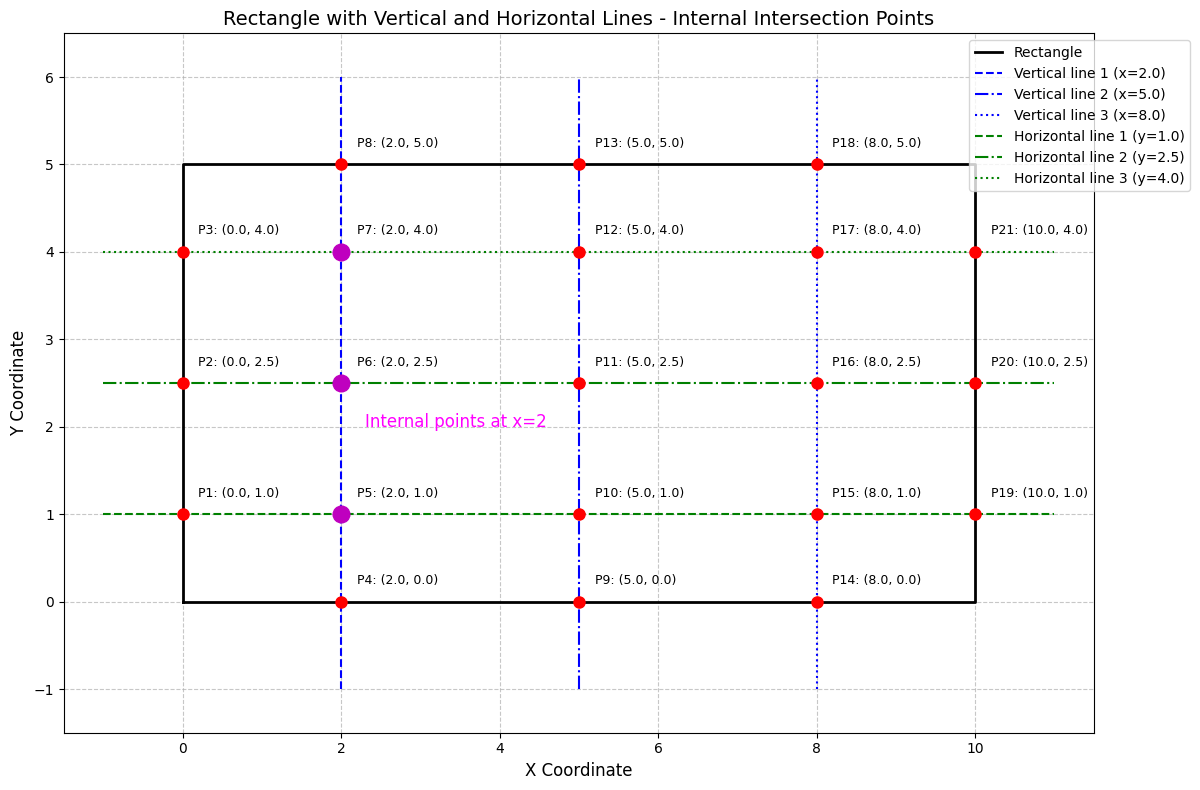


First two internal intersection points from the left on vertical line x=2:
1: (2.0, 1.0)
2: (2.0, 2.5)


In [8]:
from shapely.geometry import Polygon, LineString
import numpy as np
import matplotlib.pyplot as plt

# Create a rectangle as our main polygon
rect = Polygon([(0, 0), (10, 0), (10, 5), (0, 5)])

# Define 3 vertical lines
v1 = LineString([(2, -1), (2, 6)])  # First vertical line at x=2
v2 = LineString([(5, -1), (5, 6)])
v3 = LineString([(8, -1), (8, 6)])

# Define 3 horizontal lines
h1 = LineString([(-1, 1), (11, 1)])
h2 = LineString([(-1, 2.5), (11, 2.5)])
h3 = LineString([(-1, 4), (11, 4)])

# Find all intersection points
all_intersections = []

# Find intersections of vertical lines with horizontal lines (internal intersections only)
for v_line in [v1, v2, v3]:
    for h_line in [h1, h2, h3]:
        inter = v_line.intersection(h_line)
        if not inter.is_empty:
            all_intersections.extend(list(inter.coords))

# Add rectangle outer edges intersections for completeness in visualization
for v_line in [v1, v2, v3]:
    v_rect_intersection = rect.intersection(v_line)
    if v_rect_intersection.geom_type == 'LineString':
        v_rect_coords = list(v_rect_intersection.coords)
        all_intersections.extend(v_rect_coords)

for h_line in [h1, h2, h3]:
    h_rect_intersection = rect.intersection(h_line)
    if h_rect_intersection.geom_type == 'LineString':
        h_rect_coords = list(h_rect_intersection.coords)
        all_intersections.extend(h_rect_coords)

# Remove duplicates with rounding to handle floating point precision
unique_intersections = []
for point in all_intersections:
    rounded_point = (round(point[0], 6), round(point[1], 6))
    if rounded_point not in [(round(p[0], 6), round(p[1], 6)) for p in unique_intersections]:
        unique_intersections.append(point)

# Sort all intersections by x-coordinate (from left to right)
unique_intersections.sort(key=lambda p: (p[0], p[1]))

# Find internal intersections along the vertical line at x=2 (only with horizontal lines)
v1_internal_intersections = []
for h_line in [h1, h2, h3]:
    inter = v1.intersection(h_line)
    if not inter.is_empty:
        v1_internal_intersections.extend(list(inter.coords))

# Sort by y-coordinate
v1_internal_intersections.sort(key=lambda p: p[1])

print("\nInternal intersection points along vertical line at x=2 (with horizontal lines only):")
for i, point in enumerate(v1_internal_intersections):
    print(f"{i+1}: {point}")

# Create a visualization
plt.figure(figsize=(12, 8))

# Plot the rectangle
x, y = rect.exterior.xy
plt.plot(x, y, 'k-', linewidth=2, label='Rectangle')

# Plot vertical lines
line_styles = ['--', '-.', ':']
for i, v_line in enumerate([v1, v2, v3]):
    x, y = v_line.xy
    plt.plot(x, y, 'b' + line_styles[i % 3], linewidth=1.5, 
             label=f'Vertical line {i+1} (x={v_line.xy[0][0]})')

# Plot horizontal lines
for i, h_line in enumerate([h1, h2, h3]):
    x, y = h_line.xy
    plt.plot(x, y, 'g' + line_styles[i % 3], linewidth=1.5, 
             label=f'Horizontal line {i+1} (y={h_line.xy[1][0]})')

# Plot all intersection points
for i, point in enumerate(unique_intersections):
    plt.plot(point[0], point[1], 'ro', markersize=8)
    plt.text(point[0]+0.2, point[1]+0.2, f"P{i+1}: ({point[0]}, {point[1]})", 
             fontsize=9, ha='left')

# Highlight internal intersection points on vertical line x=2 with horizontal lines
for point in v1_internal_intersections:
    plt.plot(point[0], point[1], 'mo', markersize=12)

# Add a text label specifically for the internal intersections
plt.text(2.3, 2.0, "Internal points at x=2", fontsize=12, color='magenta')

# Add grid, labels, and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('X Coordinate', fontsize=12)
plt.ylabel('Y Coordinate', fontsize=12)
plt.title('Rectangle with Vertical and Horizontal Lines - Internal Intersection Points', fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

# Set axis limits with some padding
plt.xlim(-1.5, 11.5)
plt.ylim(-1.5, 6.5)

plt.tight_layout()
plt.show()

# Get the first two internal intersection points from the left on vertical line x=2
print("\nFirst two internal intersection points from the left on vertical line x=2:")
if len(v1_internal_intersections) >= 2:
    print(f"1: {v1_internal_intersections[0]}")  # Should be (2.0, 1.0)
    print(f"2: {v1_internal_intersections[1]}")  # Should be (2.0, 2.5)
else:
    print("Not enough internal intersection points found on vertical line x=2")